# Analisis

Using the ELT of the `fx`, `tiie` and `inpc` for each month, analyze the behavior of the exchange rate, the interbank interest rate and the inflation rate in Mexico between them

@roman avj

21 mar 24

---
# Settings

In [10]:
import os
import boto3
from pyathena import connect
import awswrangler as wr
import pandas as pd
import yaml
from dotenv import load_dotenv
from datetime import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
# load environment variables
load_dotenv()

# get config file
with open('../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [3]:
# AWS Settings
session = boto3.Session(profile_name="arquitectura")
s3 = session.client('s3')

# set region east-1 to boto3
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'

# Bucket
BUCKET_NAME = config['aws']['bucket']

# Sub Bucket
SUB_BUCKET = config['aws']['sub-bucket']

# Bucket Query
BUCKET_QUERY = config['aws']['bucket_queries']

---
# Download data

In [4]:
# Download data
df_banxico_inegi = wr.athena.read_sql_query(
    sql=f"SELECT * FROM {config['aws']['database']}.{config['aws']['elt_table_name']}",
    database=config['aws']['database'],
    ctas_approach=False, 
    boto3_session=session
)

df_banxico_inegi

,date,inpc,dollar_fx,tiie
0,2018-01-01,98.794998,19.489901,7.6311
1,2018-02-01,99.171371,18.400400,7.6600
2,2018-03-01,99.492157,18.861000,7.8294
3,2018-04-01,99.154846,18.296700,7.8503
4,2018-05-01,98.994080,18.787800,7.8455
...,...,...,...,...
70,2023-11-01,131.445007,17.930500,11.5035
71,2023-12-01,132.373001,17.214300,11.5033
72,2024-01-01,133.554993,16.919001,11.5035
73,2024-02-01,133.681000,17.133499,11.5012


In [6]:
# date as datetime
df_banxico_inegi['date'] = pd.to_datetime(df_banxico_inegi['date'])

In [7]:
# see datatypes
df_banxico_inegi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       75 non-null     datetime64[ns]
 1   inpc       74 non-null     float32       
 2   dollar_fx  75 non-null     float32       
 3   tiie       75 non-null     float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 1.6 KB


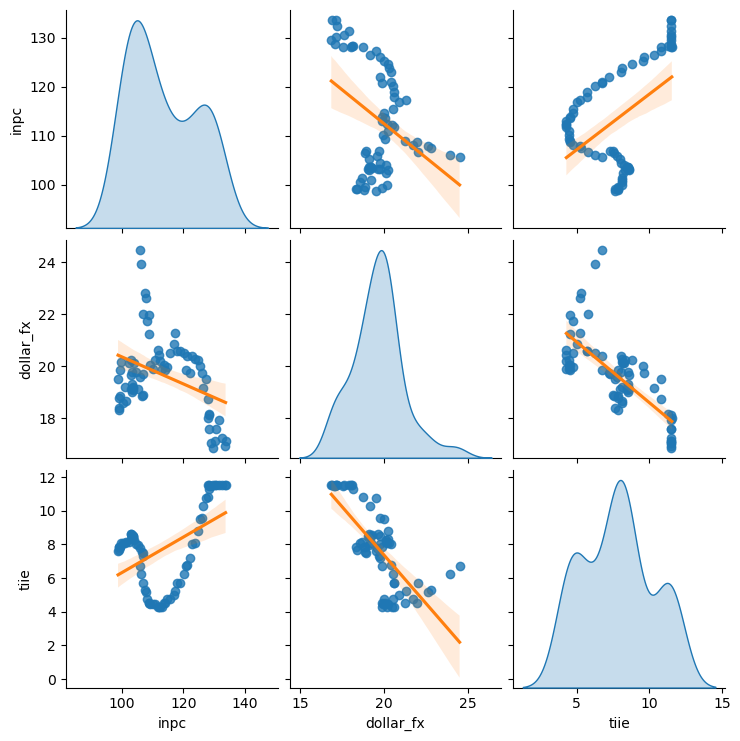

In [12]:
# pairplot
sns.pairplot(df_banxico_inegi, diag_kind='kde', kind="reg", plot_kws={'line_kws': {'color': 'C1'}})

---
# Linear Regression

### FX vs Interest Rate

In [13]:
# Fit Linear Regression dollar_fx vs tiie
# create patsy formula
formula = 'dollar_fx ~ tiie + I(tiie**2)'

# fit model
model = smf.ols(formula=formula, data=df_banxico_inegi).fit()

# print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              dollar_fx   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     48.33
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           4.91e-14
Time:                        10:40:26   Log-Likelihood:                -105.03
No. Observations:                  75   AIC:                             216.1
Df Residuals:                      72   BIC:                             223.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       20.2516      1.282     15.794   

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_67574/2806926560.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s=f'Y = {model.params[0]:.2f} + {model.params[1]:.2f}X + {model.params[2]:.2f}X^2', fontsize=12


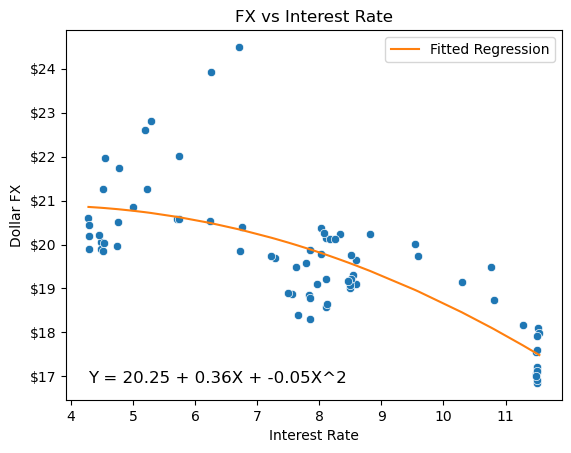

In [24]:
# plot model
fig, ax = plt.subplots()
sns.scatterplot(x='tiie', y='dollar_fx', data=df_banxico_inegi, ax=ax)
sns.lineplot(x='tiie', y=model.fittedvalues, color='C1', ax=ax, data=df_banxico_inegi, label='Fitted Regression')
# add title and labels
plt.title('FX vs Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Dollar FX')
# y label as currency
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
# add annotation of the model
plt.text(
    x=df_banxico_inegi['tiie'].min(),
    y=df_banxico_inegi['dollar_fx'].min(),
    s=f'Y = {model.params[0]:.2f} + {model.params[1]:.2f}X + {model.params[2]:.2f}X^2', fontsize=12
    )

plt.show()

### Interest Rate vs Inflation

In [26]:
# Fit Linear Regression
# create patsy formula
formula = 'tiie ~ inpc + I(inpc**2)'

# fit model
model = smf.ols(formula=formula, data=df_banxico_inegi).fit()

# print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   tiie   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     128.9
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           2.31e-24
Time:                        10:49:04   Log-Likelihood:                -110.96
No. Observations:                  74   AIC:                             227.9
Df Residuals:                      71   BIC:                             234.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      246.8693     18.819     13.118   

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_67574/1696431310.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s=f'Y = {model.params[0]:.2f} + {model.params[1]:.2f}X + {model.params[2]:.2f}X^2', fontsize=12


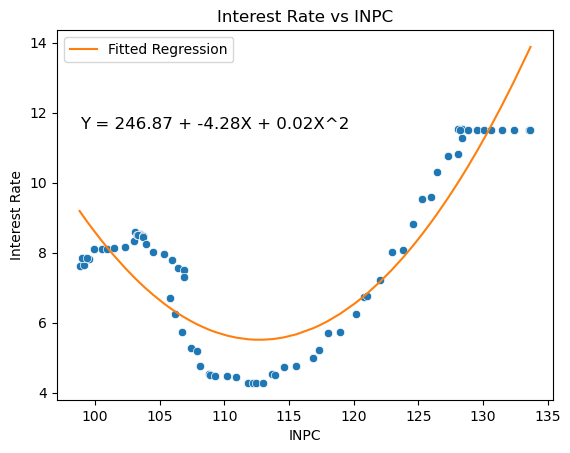

In [31]:
# plot model
fig, ax = plt.subplots()
sns.scatterplot(x='inpc', y='tiie', data=df_banxico_inegi, ax=ax)
sns.lineplot(x='inpc', y=model.fittedvalues, color='C1', ax=ax, data=df_banxico_inegi, label='Fitted Regression')
# add title and labels
plt.title('Interest Rate vs INPC')
plt.xlabel('INPC')
plt.ylabel('Interest Rate')
# add annotation of the model
plt.text(
    x=df_banxico_inegi['inpc'].min(),
    y=df_banxico_inegi['tiie'].max(),
    s=f'Y = {model.params[0]:.2f} + {model.params[1]:.2f}X + {model.params[2]:.2f}X^2', fontsize=12
    )

plt.show()


### FX vs Inflation

In [33]:
# Fit Linear Regression
# create patsy formula
formula = 'dollar_fx ~ inpc + I(inpc**2)'

# fit model
model = smf.ols(formula=formula, data=df_banxico_inegi).fit()

# print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              dollar_fx   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     40.86
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           1.55e-12
Time:                        10:53:03   Log-Likelihood:                -105.75
No. Observations:                  74   AIC:                             217.5
Df Residuals:                      71   BIC:                             224.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -109.4339     17.540     -6.239   

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_67574/2332942475.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s=f'Y = {model.params[0]:.2f} + {model.params[1]:.2f}X + {model.params[2]:.2f}X^2', fontsize=12


Text(98.79499816894531, 16.853300094604492, 'Y = -109.43 + 2.31X + -0.01X^2')

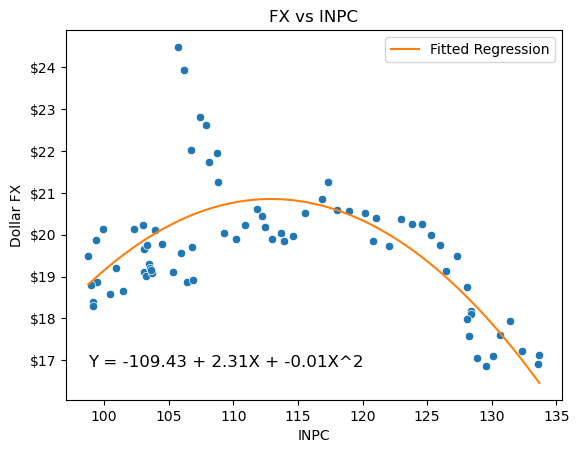

In [34]:
# plot model
fig, ax = plt.subplots()
sns.scatterplot(x='inpc', y='dollar_fx', data=df_banxico_inegi, ax=ax)
sns.lineplot(x='inpc', y=model.fittedvalues, color='C1', ax=ax, data=df_banxico_inegi, label='Fitted Regression')
# add title and labels
plt.title('FX vs INPC')
plt.xlabel('INPC')
plt.ylabel('Dollar FX')
# y label as currency
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
# add annotation of the model
plt.text(
    x=df_banxico_inegi['inpc'].min(),
    y=df_banxico_inegi['dollar_fx'].min(),
    s=f'Y = {model.params[0]:.2f} + {model.params[1]:.2f}X + {model.params[2]:.2f}X^2', fontsize=12
    )